In [1]:
from __future__ import print_function, division

### Imports: pandas', 'numpy'
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


### Imports: 'statsmodels'
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels import tsa
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from statsmodels import multivariate

### Imports: Date-related libraries 'datetime', 'calendar'
import datetime as datetime

import dateutil
import copy

### Imports: Plotting libraries 'matplotlib' & 'seaborn'
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn.apionly as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

### Import 'arch'
import arch
from arch import arch_model
print (arch.__version__)
import statsmodels.tsa.statespace.sarimax as sarima
import statsmodels.graphics.tsaplots as tsplt

4.11


- Visualizing a Time Series
Patterns in a Time Series
Additive and multiplicative Time Series
How to decompose a Time Series into its components?
Stationary and non-stationary Time Series
How to make a Time Series stationary?
How to test for stationarity?
What is the difference between white noise and a stationary series?
How to detrend a Time Series?
How to deseasonalize a Time Series?
How to test for seasonality of a Time Series?
How to treat missing values in a Time Series?
What is autocorrelation and partial autocorrelation functions?
How to compute partial autocorrelation function?
Lag Plots
How to estimate the forecastability of a Time Series?
Why and How to smoothen a Time Series?
How to use Granger Causality test to know if one Time Series is helpful in forecasting another?

https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/

In [2]:
crime = pd.read_csv("crime.csv",encoding = 'cp1252')
crime = crime.sort_values(by = ['OCCURRED_ON_DATE'])

In [3]:
crime.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
129056,I172040657,2629,Harassment,HARASSMENT,C11,397,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,MELBOURNE ST,42.291093,-71.065945,"(42.29109287, -71.06594539)"
314676,I152054279,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,B3,456,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,HARLEM ST,42.300217,-71.080979,"(42.30021684, -71.08097940)"
310350,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887,"(42.29360585, -71.07188650)"
253464,I162013546,3201,Property Lost,PROPERTY - LOST,B3,433,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813,"(42.28363434, -71.08281320)"
8793,I182061268,3201,Property Lost,PROPERTY - LOST,NaN,,NaN,2015-06-15 00:00:00,2015,6,Monday,0,Part Three,BERNARD,-1.000000,-1.000000,"(-1.00000000, -1.00000000)"


In [4]:
crime.groupby(['OFFENSE_CODE_GROUP','YEAR']).count()

INCIDENT_NUMBER  OFFENSE_CODE  \
OFFENSE_CODE_GROUP               YEAR                                  
Aggravated Assault               2015             1386          1386   
                                 2016             2365          2365   
                                 2017             2404          2404   
                                 2018             1652          1652   
Aircraft                         2015                4             4   
                                 2016                4             4   
                                 2017               22            22   
                                 2018                6             6   
Arson                            2015               11            11   
                                 2016               34            34   
                                 2017               32            32   
                                 2018               17            17   
Assembly or Gathering Violations 2015              240           240   
                                 2016              333           333   
                                 2017              243           243   
                                 2018              139           139   
Auto Theft                       2015              988           988   
                                 2016             1537          1537   
                                 2017             1393          1393   
                                 2018              933           933   
Auto Theft Recovery              2015              137           137   
                                 2016              312           312   
                                 2017              371           371   
                                 2018              231           231   
Ballistics                       2015              166           166   
                                 2016              303           303   
                                 2017              339           339   
                                 2018              173           173   
Biological Threat                2017                2             2   
Bomb Hoax                        2015               17            17   
...                                                ...           ...   
Search Warrants                  2017              347           347   
                                 2018              160           160   
Service                          2015               59            59   
                                 2016               82            82   
                                 2017               88            88   
                                 2018               56            56   
Simple Assault                   2015             2612          2612   
                                 2016             4740          4740   
                                 2017             4896          4896   
                                 2018             3578          3578   
Towed                            2015             1559          1559   
                                 2016             3223          3223   
                                 2017             3951          3951   
                                 2018             2554          2554   
Vandalism                        2015             2701          2701   
                                 2016             5063          5063   
                                 2017             4837          4837   
                                 2018             2814          2814   
Verbal Disputes                  2015             1509          1509   
                                 2016             4099          4099   
                                 2017             4436          4436   
                                 2018             3055          3055   
Violations                       2015             1354          1354   
       

In [5]:
# convert str to datetime
crime['OCCURRED_ON_DATE'] = [datetime.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S') for dt in crime['OCCURRED_ON_DATE']]
#crime['OCCURRED_ON_DATE_day'] = [x.strftime('%Y-%m-%d') for x in d]
#crime_num_df = pd.DataFrame(crime.groupby('OCCURRED_ON_DATE_day').count()['INCIDENT_NUMBER'])
#crime_num_df.index = [datetime.datetime.strptime(d, '%Y-%m-%d') for d in crime_num_df.index]
#crime_num_df.head()

In [6]:
# groupby day and count INCIDENT_NUMBER, save as a new dataframe
crime_num_df = crime.groupby(pd.Grouper(key='OCCURRED_ON_DATE', freq="d")).count()[['INCIDENT_NUMBER']]

In [7]:
crime.groupby(pd.Grouper(key='OCCURRED_ON_DATE', freq="Y")).count()[['INCIDENT_NUMBER']]

,INCIDENT_NUMBER
OCCURRED_ON_DATE,
2015-12-31,53388
2016-12-31,99114
2017-12-31,100886
2018-12-31,65685


### I. Visualization

#### 1. Visualization: General

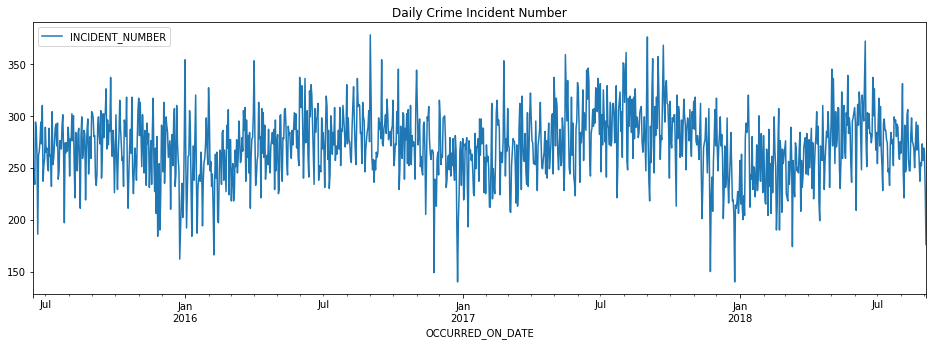

In [8]:
plt.rcParams['figure.figsize'] = [16, 5]
ax = crime_num_df.plot();
ax.set_title("Daily Crime Incident Number");

#### 2. Visualization: Boxplot of Month-wise (Seasonal) and Year-wise (trend) Distribution

In [9]:
crime_num_df.index

DatetimeIndex(['2015-06-15', '2015-06-16', '2015-06-17', '2015-06-18',
               '2015-06-19', '2015-06-20', '2015-06-21', '2015-06-22',
               '2015-06-23', '2015-06-24',
               ...
               '2018-08-25', '2018-08-26', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-01',
               '2018-09-02', '2018-09-03'],
              dtype='datetime64[ns]', name='OCCURRED_ON_DATE', length=1177, freq='D')

In [10]:
crime_num_df.groupby([crime_num_df.index, crime_num_df.index.weekday]).sum()

,,INCIDENT_NUMBER
OCCURRED_ON_DATE,OCCURRED_ON_DATE,
2015-06-15,0,249
2015-06-16,1,249
2015-06-17,2,234
2015-06-18,3,294
2015-06-19,4,289
2015-06-20,5,261
2015-06-21,6,186
2015-06-22,0,262
2015-06-23,1,266


In [11]:
def seasonal_boxplot(df_, col, type_ = 'both'):
    # set datatime as dataframe index
    df_['year'] = [d.year for d in df_.index]
    df_['month'] = [d.strftime('%b') for d in df_.index]
    
    if type_ == 'both':
        fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
        sns.boxplot(x='year', y= col, data=df_, ax=axes[0])
        sns.boxplot(x='month', y= col, data=df_.loc[~df_.year.isin([1991, 2008]), :])
    if type_ == 'month':
        fig, axes = plt.subplots(1, 1, figsize=(20,7), dpi= 80)
        sns.boxplot(x='month', y= col, data=df_.loc[~df_.year.isin([1991, 2008]), :])
    if type_ == 'year':
        fig, axes = plt.subplots(1, 1, figsize=(20,7), dpi= 80)
        sns.boxplot(x='year', y=col, data=df_)

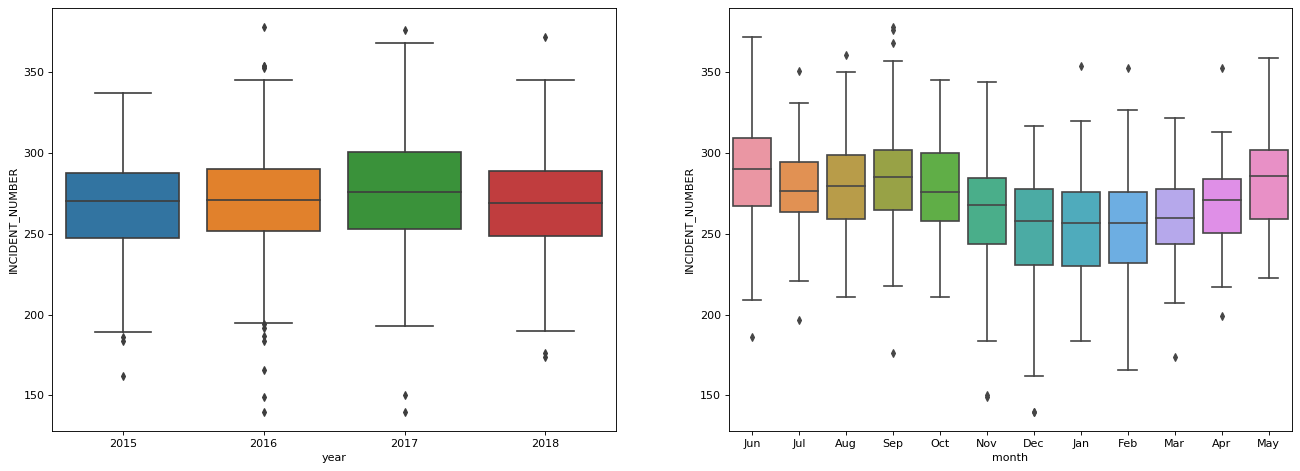

In [12]:
seasonal_boxplot(crime_num_df, 'INCIDENT_NUMBER')

In [13]:
crime_num_df

,INCIDENT_NUMBER,year,month
OCCURRED_ON_DATE,,,
2015-06-15,249,2015,Jun
2015-06-16,249,2015,Jun
2015-06-17,234,2015,Jun
2015-06-18,294,2015,Jun
2015-06-19,289,2015,Jun
2015-06-20,261,2015,Jun
2015-06-21,186,2015,Jun
2015-06-22,262,2015,Jun
2015-06-23,266,2015,Jun


In [ ]:
# Prepare data
#crime_num_df['year'] = [d.year for d in crime_num_df.index]
#crime_num_df['month'] = [d.strftime('%b') for d in crime_num_df.index]
#years = crime_num_df['year'].unique()

In [ ]:
# Draw Plot
#fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
#sns.boxplot(x='year', y='INCIDENT_NUMBER', data=crime_num_df, ax=axes[0])
#sns.boxplot(x='month', y='INCIDENT_NUMBER', data=crime_num_df.loc[~crime_num_df.year.isin([1991, 2008]), :])

### II. Patterns in Time Series: Naive Decomposition

#### 1. Patterns in Time Series: Naive Decomposition

In [14]:
# preprocess
crime_num_df['OCCURRED_ON_DATE_day'] = crime_num_df.index
crime_num_df['month'] = [d.strftime('%b') for d in crime_num_df.index]

<Figure size 1440x576 with 0 Axes>

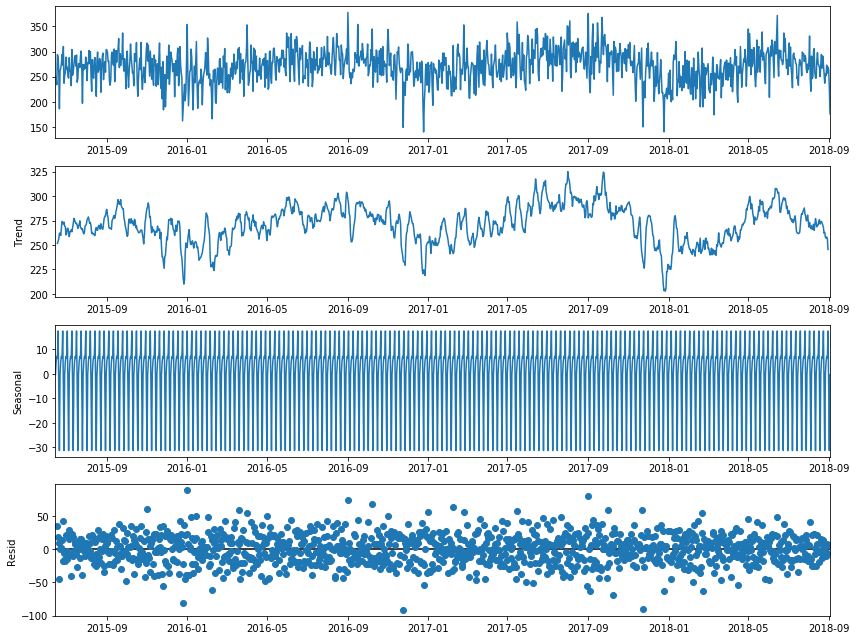

In [17]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

# model: additive or multiplicative
plt.rcParams['figure.figsize'] = [12, 9]
result = seasonal_decompose(crime_num_df[['INCIDENT_NUMBER']], model='additive')
fig = plt.figure(figsize=(20,8))
result.plot()
pyplot.show()

We can also see that the residual plot shows zero. This is a good example where the naive, or classical, decomposition was not able to separate the noise that we added from the linear trend.

The naive decomposition method is a simple one, and there are more advanced decompositions available, like Seasonal and Trend decomposition using Loess or STL decomposition.

In [ ]:
# another good example: 
series = pd.read_csv('sample.csv', header=0, index_col=0)

# set index to DateTimeIndex
series.reset_index(inplace=True)
series['Month'] = pd.to_datetime(series['Month'])
series = series.set_index('Month')
series.plot()
pyplot.show()

result = seasonal_decompose(series, model='multiplicative')
result.plot()
pyplot.show()

__Interpretation:__ We can see that the trend and seasonality information extracted from the series does seem reasonable. The residuals are also interesting, showing periods of high variability in the early and later years of the series.

#### 2. Patterns in Time Series: Hodrick–Prescott Filter (Minor Seasonality, Macroeconomic data)

https://www.pythonforfinance.net/2019/07/22/time-series-decomposition-prediction-in-python/

The Hodrick–Prescott filter (also known as Hodrick–Prescott decomposition) is a mathematical tool used in macroeconomics, especially in real business cycle theory, to remove the cyclical component of a time series from raw data.

The HP filter is a technique commonly used with macro-economic series that have a trend (long-term movements), business cycle and irregular parts (short-term fluctuations). It constructs the trend component by solving an optimisation problem. It aims to form the smoothest trend estimate that minimises the squared distances to the original series. In other words, it has to find equilibrium between the smoothness of the trend and its closeness to the original.

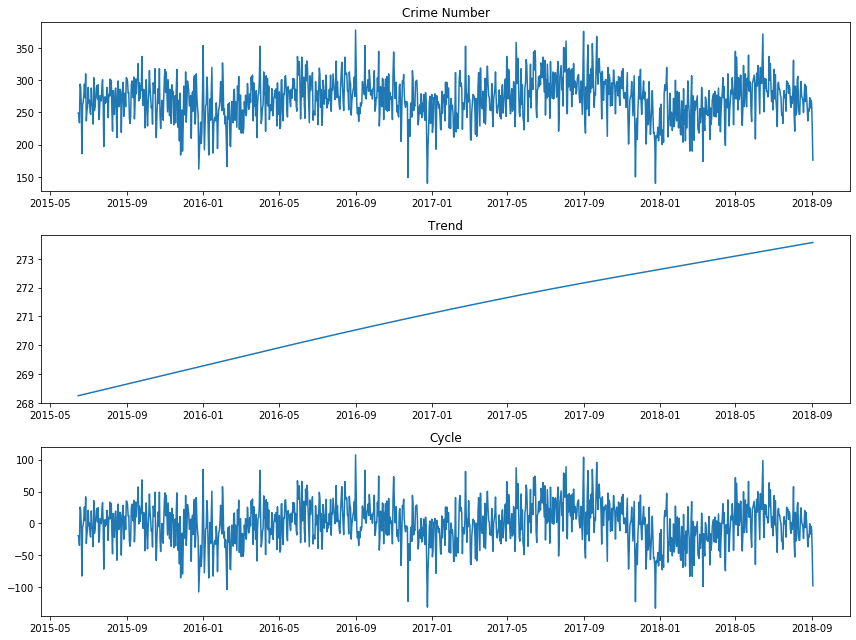

In [19]:
cycle, trend = sm.tsa.filters.hpfilter(crime_num_df[['INCIDENT_NUMBER']], 1600*90**4)
fig, ax = plt.subplots(3,1)
ax[0].plot(crime_num_df[['INCIDENT_NUMBER']])
ax[0].set_title('Crime Number')
ax[1].plot(trend)
ax[1].set_title('Trend')
ax[2].plot(cycle)
ax[2].set_title('Cycle')
plt.tight_layout()
plt.show()

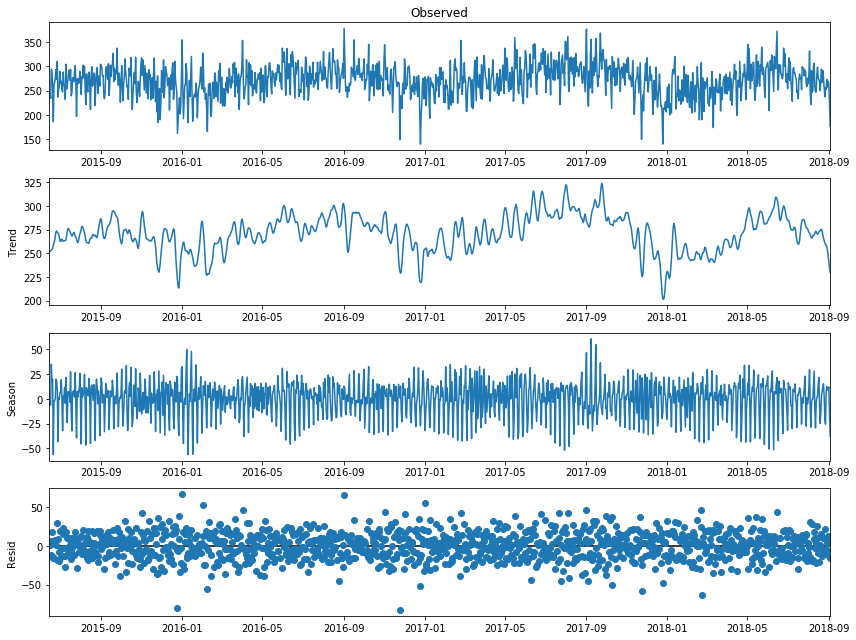

In [20]:
# STL decomposition
from statsmodels.tsa.seasonal import STL
result = STL(crime_num_df[['INCIDENT_NUMBER']]).fit()
chart = result.plot()
plt.show()

### ACF and PACF Plots

In [21]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_ylabel('Number of Incidents')
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()

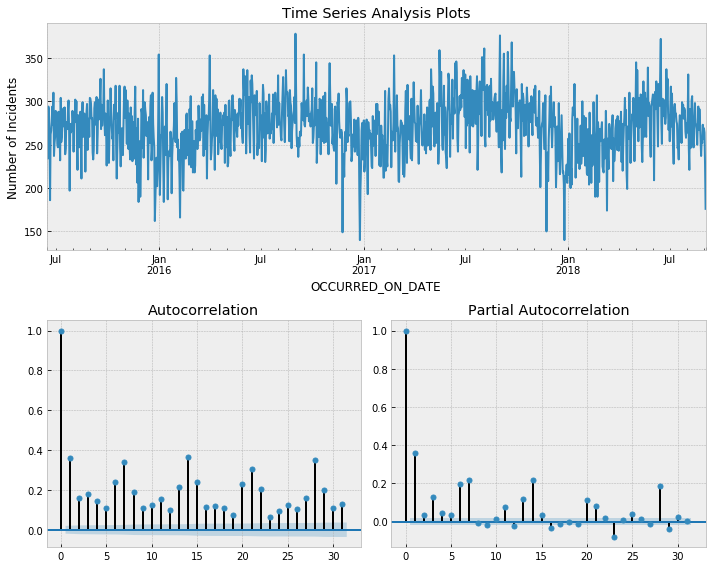

In [23]:
data = crime_num_df['INCIDENT_NUMBER'] # remember to remove NA
tsplot(data)

__Interpretation:__
In PACF, there are significant correlations at the first or second lag, followed by correlations that are not significant. An autoregressive term in the data. The number of significant correlations indicate the order of the autoregressive term.

__Seasonality:__ There are seasonal effects as the spikes of the ACF indicate -> weekly.

https://support.minitab.com/en-us/minitab/19/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

### Stationarity Test

In [24]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(crime_num_df['INCIDENT_NUMBER'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.442352460424236
p-value: 0.009597072983387396
Critial Values:
   1%, -3.436029294258502
Critial Values:
   5%, -2.864047798131664
Critial Values:
   10%, -2.5681052115616243


The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

__Stationary in this case.__

#### To fix nonstationarity:

1. Differencing the Series (once or more)
2. Take the log of the series
3. Take the nth root of the series
4. Combination of the above

In [25]:
# Solution: take difference
diff_n = 1
original_arr = np.array(crime_num_df['INCIDENT_NUMBER'])
lagged_arr = np.array(crime_num_df[['INCIDENT_NUMBER']].shift(diff_n)['INCIDENT_NUMBER'])

In [26]:
crime_num_df['first_diff'] = list(original_arr - lagged_arr)

In [27]:
result = adfuller(crime_num_df[['first_diff']].dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.859811409592819
p-value: 1.456071801218219e-19
Critial Values:
   1%, -3.436029294258502
Critial Values:
   5%, -2.864047798131664
Critial Values:
   10%, -2.5681052115616243


__If stationary, we can conduct OLS to time series data.__

### De-trend a Time Series

1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.

2. Subtract the trend component obtained from time series decomposition we saw earlier.

3. Subtract the mean

4. Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

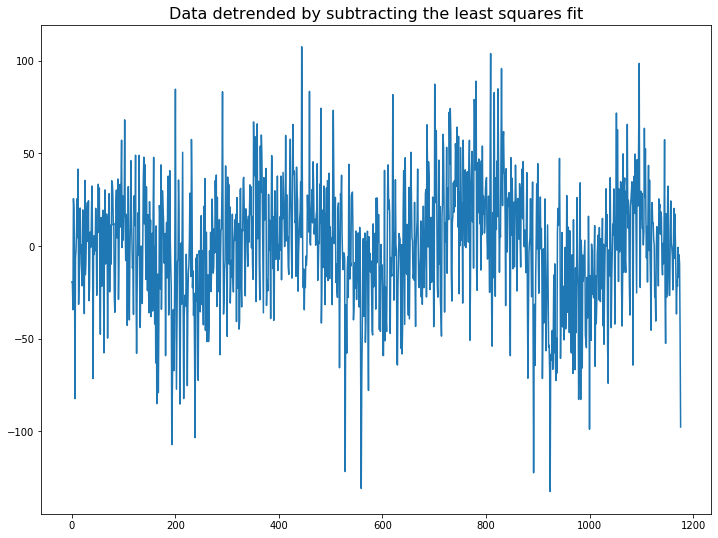

In [28]:
from scipy import signal

detrended = signal.detrend(crime_num_df['INCIDENT_NUMBER'])
plt.plot(detrended)
plt.title('Data detrended by subtracting the least squares fit', fontsize=16);

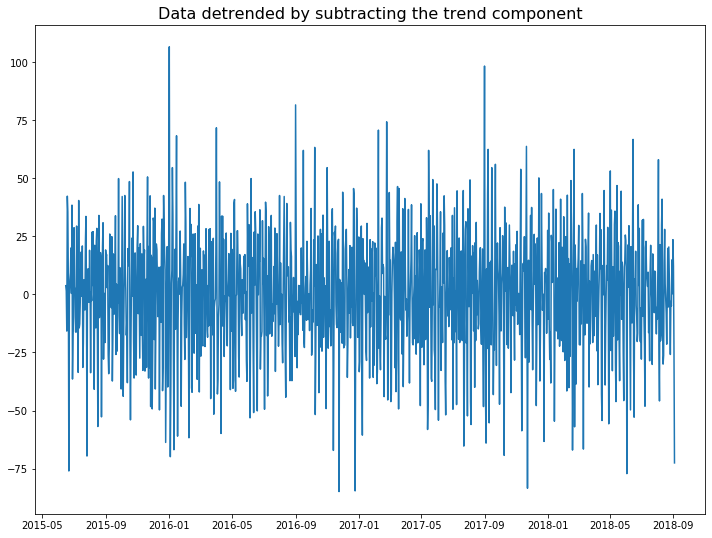

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_mul = seasonal_decompose(crime_num_df['INCIDENT_NUMBER'], model='multiplicative', extrapolate_trend='freq')
detrended = crime_num_df['INCIDENT_NUMBER'] - result_mul.trend
plt.plot(detrended)
plt.title('Data detrended by subtracting the trend component', fontsize=16);

### De-seasonalize a Time Series

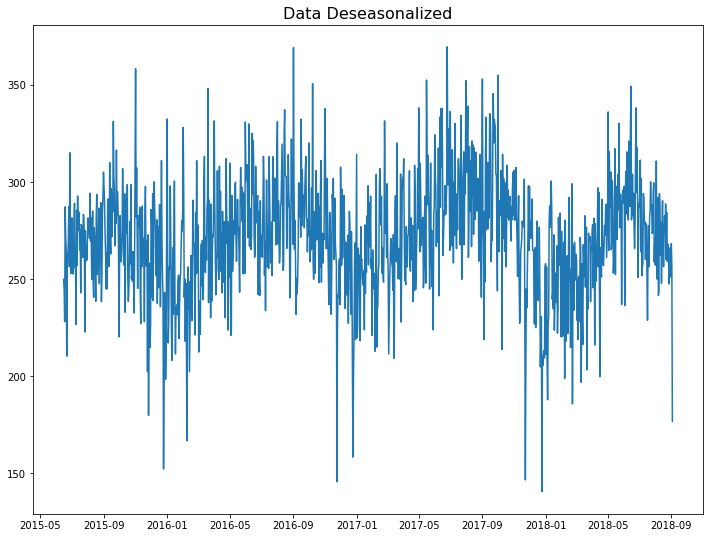

In [30]:
result_mul = seasonal_decompose(crime_num_df['INCIDENT_NUMBER'], model='multiplicative', extrapolate_trend='freq')
deseasonalized = crime_num_df['INCIDENT_NUMBER'] / result_mul.seasonal

plt.plot(deseasonalized)
plt.title('Data Deseasonalized', fontsize=16);

### Test for Seasonality

The common way is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar:

- Hour of day
- Day of month
- Weekly
- Monthly
- Yearly

However, if you want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. More on the ACF in the upcoming sections. But when there is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

For example, the drug sales time series is a monthly series with patterns repeating every year. So, you can see spikes at 12th, 24th, 36th.. lines.

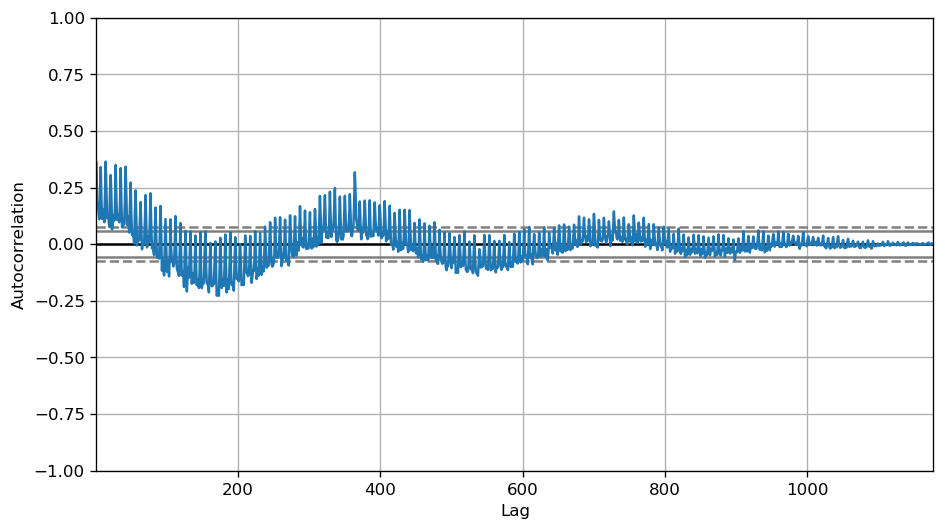

In [31]:
from pandas.plotting import autocorrelation_plot

plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(crime_num_df['INCIDENT_NUMBER'].tolist())

### ARCH/GARCH: Choose the Best Model

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [ ]:
res_tup = _get_best_model(data)

In [ ]:
model = arch_model(data, p=4, o=1, q=4, vol='GARCH')
res = model.fit()
print(res.summary())

### Cross Correlation VAR(1)

#### T Test Assumptions:
- Both A and B are normally distributed
- A(xi) and B(xi) are independent of each other.

In [93]:
JPM = pd.read_csv('JPM.csv').set_index('Date').iloc[1:,:]
RDSA = pd.read_csv('RDS-A.csv').set_index('Date').iloc[:-2,:]

JPM_arr = np.log(np.array(JPM['Close']))
RDSA_arr = np.log(np.array(RDSA['Close']))

# log
data_cc = pd.DataFrame({
    'RDSA': np.log(RDSA_arr),
    'JPM':np.log(JPM_arr)})

# first difference
RDSA_df_1 = data_cc['RDSA'] - data_cc['RDSA'].shift(1)
JPM_df_1 = data_cc['JPM'] - data_cc['JPM'].shift(1)

df = pd.DataFrame({'JPM':JPM_df_1.dropna(),
             'RDSA':RDSA_df_1.dropna()})

### VAR Model 

Fit VAR model for VAR(1) to estimate the significance of coefficient (cross-correlation coefficients) by looking at T-stats and p-values.

In [98]:
from statsmodels.tsa.api import VAR

model = VAR(df)
results = model.fit(1)
results.summary()

/Users/yiliwang/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, Jan, 2020
Time:                     11:07:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -23.9885
Nobs:                     248.000    HQIC:                  -24.0392
Log likelihood:           2287.32    FPE:                3.50776e-11
AIC:                     -24.0735    Det(Omega_mle):     3.42441e-11
--------------------------------------------------------------------
Results for equation JPM
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.000253         0.000159            1.588           0.112
L1.JPM         -0.010547         0.070252           -0.150           0.881
L1.RDSA        -0.033660         0.067483           -0.499           0.618

Results fo

In [116]:
# Descriptive of data: ACF and PACF plots
# tsplot(RDSA_df_1.dropna())
# tsplot(JPM_df_1.dropna())

__Interpretation of ACF and PACF:__ White noise for each variable's first difference.

### Cross-Correlation Function Plot

In [36]:
from numpy.fft import fft, ifft, fft2, ifft2, fftshift

def cross_correlation_using_fft(x, y):
    f1 = fft(x)
    f2 = fft(np.flipud(y))
    cc = np.real(ifft(f1 * f2))
    return fftshift(cc)

# shift &lt; 0 means that y starts 'shift' time steps before x # shift &gt; 0 means that y starts 'shift' time steps after x
def compute_shift(x, y):
    assert len(x) == len(y)
    c = cross_correlation_using_fft(x, y)
    assert len(c) == len(x)
    zero_index = int(len(x) / 2) - 1
    shift = zero_index - np.argmax(c)
    return shift

In [115]:
# calculate the cross-correlation plot 
# cross_correlation_using_fft(JPM_df_1.dropna(),RDSA_df_1.dropna())

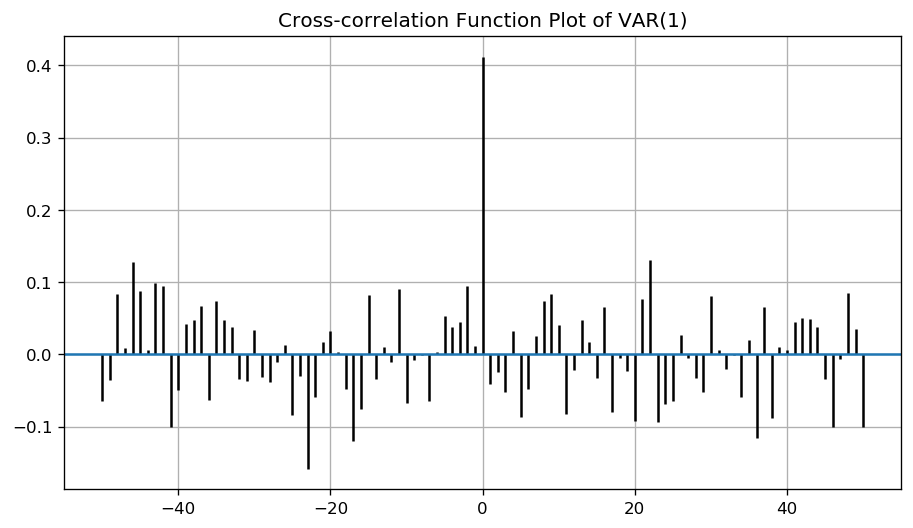

In [57]:
# REMEMBER: drop NA before plotting VAR(1)
plt.xcorr(JPM_df_1.dropna(),RDSA_df_1.dropna(), usevlines=True, maxlags=50, normed=True);
plt.grid(True)
#plt.axhline(0.2, color='blue', linestyle='dashed', lw=2)
#plt.ylim([0, 1])
plt.title("Cross-correlation Function Plot of VAR(1)");

__Interpretation:__ Cross-correlation is the largest when lag = 0.

### Cointegration:

If significant at lag = 0, two time series are influenced by the same source of fluctuatioin.

If significant at lag != 0, one time series must granger cause another one. Conduct __Granger Causality__ test. 

In [103]:
import statsmodels.tsa.stattools as ts 

result=ts.coint(df['JPM'], df['RDSA']) # t stats, p-value, C.I
result

(-15.748760265017378,
 9.78775706045189e-28,
 array([-3.94114601, -3.36087844, -3.06159584]))

#### Significance Test for Lag = 0:

example: https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/cross-correlation/interpret-the-results/all-statistics-and-graphs/

On this plot, the correlation at lag 0 is approximately 0.41. Because 0.41 > ${\frac{2}{\sqrt{n-|k|}}}$ = 0.12674   the correlation is significant at confidence level (α) of approximately 5%.（You can conclude that the water moves from the upstream location to the downstream location in two days.）

where k = lag, n = number of observations.

In [58]:
# Alternatively, find the optimal shift j to maximize cross correlation 
compute_shift(JPM_df_1.dropna(),RDSA_df_1.dropna())

0

cross-correlation lag := VAR(lag)

### Granger Causality

In [67]:
from statsmodels.tsa.stattools import grangercausalitytests

def grangers_causation_matrix(data, variables, maxlag=12, test='ssr_chi2test', verbose=True):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            null = str(c)+' does not Granger Cause '+str(r)
            
            if verbose: 
                print(f'Y = {r}, X = {c}')
                print(null)
                print(pd.DataFrame({'Lags': list(range(maxlag)),'P Values': p_values}))
                print("\n")
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    #df.columns = [var + '_x' for var in variables]
    #df.index = [var + '_y' for var in variables]
    
    #return df    

In [99]:
grangers_causation_matrix(df, variables = df.columns,maxlag=12, verbose=True)    

Y = JPM, X = JPM
JPM does not Granger Cause JPM
    Lags  P Values
0      0       1.0
1      1       1.0
2      2       1.0
3      3       1.0
4      4       1.0
5      5       1.0
6      6       1.0
7      7       1.0
8      8       1.0
9      9       1.0
10    10       1.0
11    11       1.0


Y = RDSA, X = JPM
JPM does not Granger Cause RDSA
    Lags  P Values
0      0    0.7926
1      1    0.3166
2      2    0.3148
3      3    0.4277
4      4    0.4090
5      5    0.5568
6      6    0.5918
7      7    0.6075
8      8    0.6488
9      9    0.5621
10    10    0.3411
11    11    0.4006


Y = JPM, X = RDSA
RDSA does not Granger Cause JPM
    Lags  P Values
0      0    0.6158
1      1    0.6139
2      2    0.5418
3      3    0.6637
4      4    0.5211
5      5    0.6499
6      6    0.7025
7      7    0.5314
8      8    0.6337
9      9    0.6480
10    10    0.6014
11    11    0.6574


Y = RDSA, X = RDSA
RDSA does not Granger Cause RDSA
    Lags  P Values
0      0       1.0
1      1       

In [117]:
x = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
y = np.array([5, 20, 14, 32, 22, 38])

In [119]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(x, y)

In [120]:
model.feature_importances_

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'